In [1]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt
import common_utils

import random

In [570]:
d = 15

# multiplication table
mul_table = torch.zeros(d, d, dtype=torch.int)

for i in range(d):
    for j in range(d):
        mul_table[i, j] = (i + j) % d
        
# distribution of each entry
probs = torch.ones(d, d)

# multiplication table
mul_table = torch.zeros(d, d, dtype=torch.int)

for i in range(d):
    for j in range(d):
        mul_table[i, j] = (i + j) % d
        
n = d * d

X = torch.zeros(n, 2 * d)
Y = torch.zeros(n, d)
targets = torch.zeros(n, dtype=torch.int)

for i in range(n):
    j, k = i // d, i % d
    X[i, j] = 1
    X[i, k + d] = 1
    Y[i, mul_table[j, k]] = 1
    targets[i] = mul_table[j, k]
    
# Normalized one hot.
X = X - 2 / d
Y = Y - 1 / d

# Pick the dataset
probs = torch.rand(n)
prob_thres = 0.2

sorted_probs, indices = probs.sort(descending=True)
n_train = (sorted_probs >= prob_thres).nonzero().squeeze().size(0)
n_test = d*d - n_train

print(f"{n_train} training samples, {n_test} test_samples")

X_train = X[indices[:n_train],:]
Y_train = Y[indices[:n_train],:]

X_test = X[indices[n_train:],:]
Y_test = Y[indices[n_train:],:]

_, train_vis_indices = targets[indices[:n_train]].sort()

torch.save(dict(train_indices = indices[:n_train], test_indices = indices[n_train:]), "dataset.pt")

181 training samples, 44 test_samples


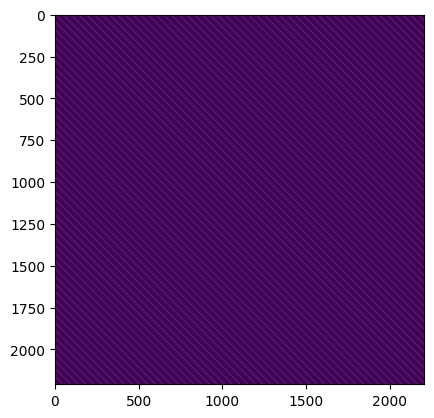

In [132]:
plt.imshow(Y @ Y.t())

In [111]:
# random weights
K = 128
W = torch.randn(2*d, K)

In [453]:
def compute_dF(F, Y):
    U, D, Vt = torch.linalg.svd(F, full_matrices=False)
    
    eps = 1e-1

    Y_proj = U.t() @ Y
    D_inv = 1 / (D + eps)
    
    # dF = U @ (1 - D * D_inv).diag() @ Y_proj @ Y_proj.t() @ (D_inv[:,None] * Vt)
    
    # est_W = Vt.t() @ (Y_proj / (D[:,None] + eps))
    est_W = Vt.t() @ (Y_proj * D_inv[:,None])
    hatY = F @ est_W
    dF = (Y - hatY) @ est_W.t()
    
    loss = ((Y - hatY).pow(2).sum() / Y.size(0)).sqrt()
    
    # plt.imshow(U @ (1 - D * D_inv).diag() @ U.t())
    # plt.show()
    # print(1 - D * D_inv)
    return dF, est_W, loss, hatY, D, Y_proj @ Y_proj.t()

In [195]:
def compute_dF2(F, Y):
    U, D, Vt = torch.linalg.svd(F, full_matrices=False)
    
    eps = 1e-3

    Y_proj = U.t() @ Y
    D_inv = 1 / (D + eps)
    
    P = U @ (1 - D * D_inv).diag() @ U.t() + torch.eye(U.size(0)).to(F.device) - U@U.t()
    dF = P @ Y @ Y_proj.t() @ (D_inv[:,None] * Vt)
    
    # dF = eps * Y @ Y_proj.t() @ (D_inv[:,None] * Vt)
    # dF = eps * Y @ Y_proj.t() @ (D_inv[:,None] * Vt)
    # dF = (eps * U @ (D_inv[:,None] * U.t()) + torch.eye(U.size(0)).to(F.device) - U@U.t()) @ Y @ Y_proj.t() @ (D_inv[:,None] * Vt)

    # dF = (torch.eye(U.size(0)).to(F.device) - U@U.t()) @ Y @ Y_proj.t() @ (D_inv[:,None] * Vt)
    # dF = Y @ Y_proj.t() @ (D_inv[:,None] * Vt)
    
    # dF = (torch.eye(U.size(0)).to(F.device) - U@U.t()) @ Y @ Y_proj.t() @ Vt
    # dF = Y @ Y_proj.t() @ Vt

    return dF

In [495]:
def compute_dF3(F, Y):
    U, D, Vt = torch.linalg.svd(F, full_matrices=False)
    
    eps = 1e-1

    Y_proj = U.t() @ Y
    D_inv = 1 / (D + eps)
    
    dF = eps * (U * D_inv[None,:]) @ Y_proj @ Y_proj.t() @ (D_inv[:,None] * Vt)
    
    # dF = eps * Y @ Y_proj.t() @ (D_inv[:,None] * Vt)
    # dF = eps * Y @ Y_proj.t() @ (D_inv[:,None] * Vt)
    # dF = (eps * U @ (D_inv[:,None] * U.t()) + torch.eye(U.size(0)).to(F.device) - U@U.t()) @ Y @ Y_proj.t() @ (D_inv[:,None] * Vt)

    # dF = (torch.eye(U.size(0)).to(F.device) - U@U.t()) @ Y @ Y_proj.t() @ (D_inv[:,None] * Vt)
    # dF = Y @ Y_proj.t() @ (D_inv[:,None] * Vt)
    
    # dF = (torch.eye(U.size(0)).to(F.device) - U@U.t()) @ Y @ Y_proj.t() @ Vt
    # dF = Y @ Y_proj.t() @ Vt

    return dF, D, Y_proj @ Y_proj.t()

In [510]:
def compute_dF4(F, Y):
    U, D, Vt = torch.linalg.svd(F, full_matrices=False)
    
    eps = 1e-1

    Y_proj = U.t() @ Y
    D2_inv = 1 / (D.pow(2) + eps)
    
    # dF = U @ (1 - D * D_inv).diag() @ Y_proj @ Y_proj.t() @ (D_inv[:,None] * Vt)
    
    # est_W = Vt.t() @ (Y_proj / (D[:,None] + eps))
    est_W = Vt.t() @ (Y_proj * (D * D2_inv)[:,None])
    hatY = F @ est_W
    dF = (Y - hatY) @ est_W.t()
    
    loss = ((Y - hatY).pow(2).sum() / Y.size(0)).sqrt()
    
    # plt.imshow(U @ (1 - D * D_inv).diag() @ U.t())
    # plt.show()
    # print(1 - D * D_inv)
    return dF, est_W, loss, hatY, D, Y_proj @ Y_proj.t()

In [ ]:
F = X@W
F[F < 0] = 0 # Relu

dF, _, _ = compute_dF(F, Y)
plt.imshow(dF)
plt.show()

# shuffle W
indices = list(range(K))
random.shuffle(indices)
F_shuffled = F[:, indices]

dF_shuffled, _, _ = compute_dF(F_shuffled, Y)
dF2 = torch.zeros(n, K)
dF2[:, indices] = dF_shuffled

plt.subplot(1, 2, 1)
plt.imshow(dF)
plt.subplot(1, 2, 2)
plt.imshow(dF2)
plt.show()

print((dF-dF2).norm() / dF.norm())

iter0:  0.5918206572532654
iter100:  0.9924777150154114
iter200:  0.9983307719230652
iter300:  0.9993402361869812
iter400:  0.9996622800827026
iter500:  0.9998002052307129
iter600:  0.9998699426651001
iter700:  0.999909520149231
iter800:  0.9999339580535889
iter900:  0.9999498724937439


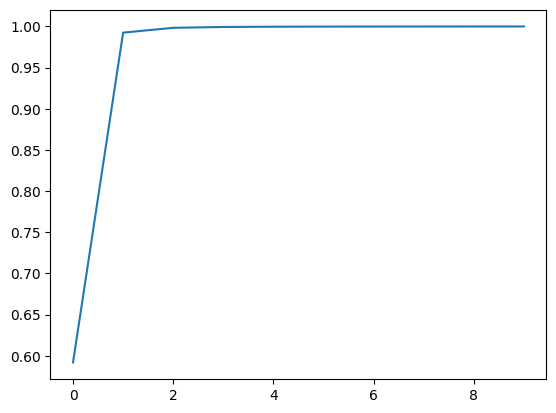

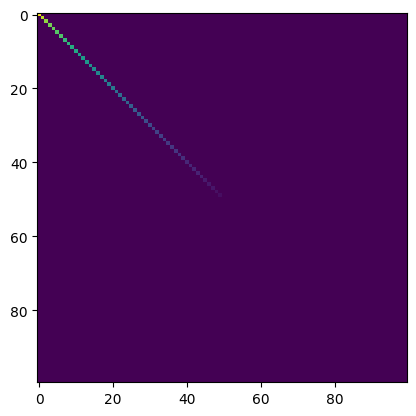

In [496]:
K = 128
d = 17
lower_W = torch.randn(2*d, K).cuda()

# F = X_train @ lower_W
# F = F.pow(2)
# F[F<0] = 0
# F = F - F.mean(dim=0, keepdim=True)

n = 100

F = torch.randn(n, K).cuda()
# Y_train = (torch.rand(n, n // 2).cuda() > 0.5).float() * 10
# Make Y_train one hot

n_class = 50
# Y_train = torch.randint(0, n_class, (n,))
# Y_train = torch.nn.functional.one_hot(Y_train).float().cuda()

# Y_train = torch.rand(n, n_class).cuda()
# Y_train = Y_train / Y_train.sum(dim=1, keepdim=True)

Y_train = torch.randn(n, n_class).cuda()
Y_train = Y_train / Y_train.norm(dim=1, keepdim=True,p=3)

alpha = 100
Ds = []
diag_strs = []

for t in range(1000):
    dF, D, UTYYTU = compute_dF3(F, Y_train)
    Ds.append(D)

    if t % 100 == 0:
        # plt.imshow(UTYYTU.cpu())
        # plt.title(f"iter{t}")
        # plt.show()
        UTYYTU2 = UTYYTU.pow(2)
        diag_strength = (UTYYTU2.diag().sum() / UTYYTU2.sum()).sqrt().item()
        print(f"iter{t}: ", diag_strength)
        diag_strs.append(diag_strength)

    F += alpha * dF
    
plt.plot(diag_strs)
plt.show()
plt.imshow(UTYYTU.cpu())

In [470]:
Y_train.type()

'torch.cuda.LongTensor'

In [427]:
UTYYTU2 = UTYYTU.pow(2).cpu()

print(UTYYTU2.diag().sum() / UTYYTU2.sum())

tensor(0.9705)


In [571]:
K = 256
d = 15
W = nn.Linear(2*d, K, bias=False)

X_train = X_train.cuda()
W = W.cuda()
Y_train = Y_train.cuda()

X_test = X_test.cuda()
Y_test = Y_test.cuda()

with torch.no_grad():
    F = W(X_train)
    F = F ** 2

    dF, est_upper_W, loss_train, hatY, D, UTYYU = compute_dF4(F, Y_train)
    # Check the structure of dF
    

In [565]:
# Run some dynamics given the backpropagated gradient.

K = 256
d = 15
W = nn.Linear(2*d, K, bias=False)

# save the initial value
torch.save(W.state_dict(), "W.pt")

X_train = X_train.cuda()
W = W.cuda()
Y_train = Y_train.cuda()

X_test = X_test.cuda()
Y_test = Y_test.cuda()

# optimizer
optimizer = torch.optim.Adam(W.parameters(), lr=0.01, weight_decay=5e-5)

est_upper_W = None

hatYs = []
Ds = []

activation = "sqr"

for t in range(4000):
    optimizer.zero_grad()
    
    # 
    W.train()
    F = W(X_train)
    
    if activation == "sqr":
        F = F.pow(2)
    elif activation == "relu":
        F[F<0] = 0
    else:
        raise RuntimeError(f"unknown activation {activation}")
        
    # Do normalization
    F = F - F.mean(dim=0, keepdim=True)
    # F = F / (F.pow(2).mean(dim=0, keepdim=True) + 1e-1).sqrt()
    
    with torch.no_grad():
        dF, est_upper_W, loss_train, hatY, D, UTYYU = compute_dF4(F, Y_train)
        # dF = compute_dF2(F, Y_train)
#         if t % 100 == 0:
#             plt.imshow(dF2[train_vis_indices, :].cpu())
#             plt.title(f"iter{t}")
#             plt.show()
    
    if t % 100 == 0:
        print(f"iter {t}")
        if est_upper_W is not None:
            W.eval()
            with torch.no_grad():
                first_layer = W(X_test)
                if activation == "sqr":
                    first_layer = first_layer.pow(2)
                elif activation == "relu":
                    first_layer[first_layer < 0] = 0
                    
                loss_test = ((first_layer @ est_upper_W - Y_test).pow(2).sum() / n_test).sqrt()
            print(loss_train, loss_test)
            W.train()
            
        w = W.weight.detach()

        indices = (w.norm(dim=1) > 0.2).nonzero().squeeze()
        print(indices.size())

        sum_freq_contr = 0
        sum_freq_max = 0

        for i in indices:
            v = w[i, :d].cpu()
            contr, max_value = freq_contr(v)
            sum_freq_contr += contr
            sum_freq_max += max_value

        normalized_freq_contr = sum_freq_contr / sum_freq_max
        print(f"{normalized_freq_contr=}")
        
        hatYs.append(hatY)
        
        # plt.imshow(dF[train_vis_indices,:].cpu())
        # Stable rank
        # print(D.pow(2).sum() / D[0].pow(2))
        # plt.show()
        Ds.append(D.cpu())
        UTYYU2 = UTYYU.pow(2)
        diag_energy = (UTYYU2.diag().sum() / UTYYU2.sum()).sqrt()
        # plt.imshow(UTYYU.cpu())
        # plt.show()
        print(diag_energy)
        # plt.imshow(F.detach().cpu())
        # plt.show()
        # plt.plot(D.cpu(), label=f"iter{t}")
    
    loss = -(dF * F).sum() / F.size(0) * 2
    loss.backward()
    
    optimizer.step()
    
# plt.legend()
# plt.show()


iter 0
tensor(0.5865, device='cuda:0') tensor(1.2086, device='cuda:0')
torch.Size([256])
normalized_freq_contr=tensor(-1.8879, dtype=torch.float64)
tensor(0.3042, device='cuda:0')
iter 100
tensor(0.0182, device='cuda:0') tensor(0.8679, device='cuda:0')
torch.Size([256])
normalized_freq_contr=tensor(-0.7168, dtype=torch.float64)
tensor(0.6693, device='cuda:0')
iter 200
tensor(0.0176, device='cuda:0') tensor(0.7522, device='cuda:0')
torch.Size([256])
normalized_freq_contr=tensor(-0.3724, dtype=torch.float64)
tensor(0.7649, device='cuda:0')
iter 300
tensor(0.0174, device='cuda:0') tensor(0.8207, device='cuda:0')
torch.Size([256])
normalized_freq_contr=tensor(-0.1162, dtype=torch.float64)
tensor(0.8248, device='cuda:0')
iter 400
tensor(0.0173, device='cuda:0') tensor(0.9675, device='cuda:0')
torch.Size([256])
normalized_freq_contr=tensor(0.0573, dtype=torch.float64)
tensor(0.8702, device='cuda:0')
iter 500
tensor(0.0171, device='cuda:0') tensor(1.0987, device='cuda:0')
torch.Size([256])
no

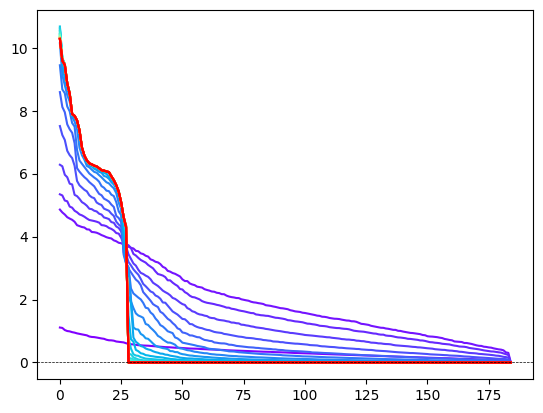

In [568]:
### import numpy as np

colors = plt.cm.rainbow(np.linspace(0,1,len(Ds)))

for t, D in enumerate(Ds):
    plt.plot(D.cpu(), c=colors[t])
    
plt.axhline(0, color='k', linewidth=0.5, linestyle='--')
    
plt.show()

In [345]:
colors[0]

array([0.5, 0. , 1. , 1. ])

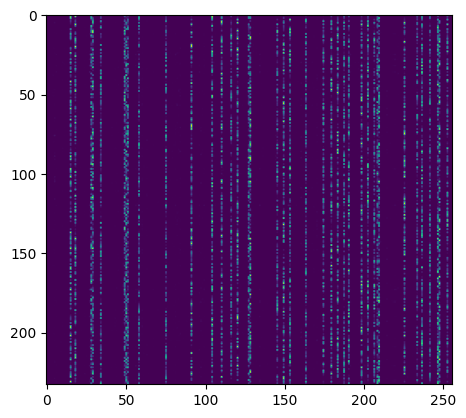

In [326]:
plt.imshow(F.detach().cpu())

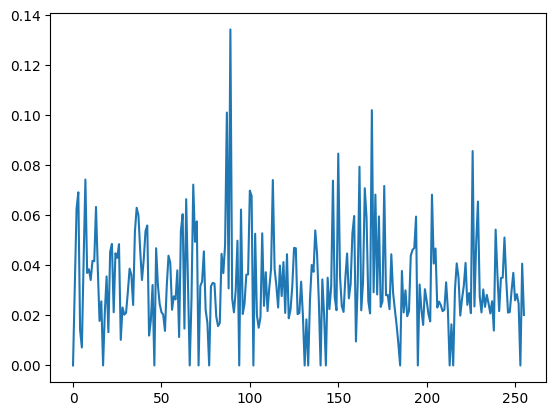

In [327]:
plt.plot(dF.norm(dim=0).cpu())

In [229]:
### errYs2 = torch.stack(errYs)

delta_err = (errYs2[1:,:,:] - errYs2[:-1,:,:]).reshape(29, 228*17)
delta_err.norm(dim=1) / errYs2[:-1,:,:].reshape(29, 228*17).norm(dim=1) 

#plt.imshow((errYs2[1:,:,:] - errYs[:-1,:,:]).reshape(-1, 228*17).norm(dim=1)

tensor([0.9980, 0.4931, 0.2049, 0.1737, 0.1622, 0.1605, 0.1651, 0.1761, 0.1888,
        0.1953, 0.2045, 0.2273, 0.2486, 0.2568, 0.2736, 0.3151, 0.3492, 0.3517,
        0.3805, 0.3689, 0.3846, 0.3820, 0.3265, 0.4650, 1.2207, 0.8016, 3.7617,
        0.9728, 1.7020], device='cuda:0')

RuntimeError: The size of tensor a (289) must match the size of tensor b (228) at non-singleton dimension 0

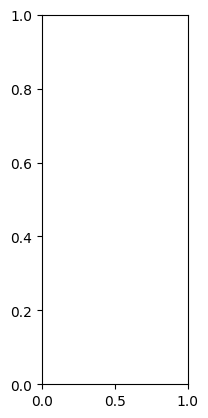

In [237]:
t = 27

plt.subplot(1,3,1)
plt.imshow(Y - errYs2[t,:,:].cpu())
print(hatYs2[t,:,:].norm())

plt.subplot(1,3,2)
plt.imshow(Y - errYs2[t+1,:,:].cpu())
print(errYs2[t+1,:,:].norm())

plt.subplot(1,3,3)
plt.imshow(errYs2[t+1,:,:].cpu() - errYs2[t,:,:].cpu())
print((errYs2[t+1,:,:] - errYs2[t,:,:]).norm())

plt.show()

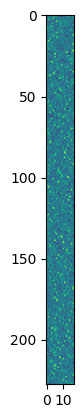

In [255]:
plt.imshow((Y_train-hatYs[-9]).cpu())

In [249]:
hatYs[-1]

RuntimeError: The size of tensor a (289) must match the size of tensor b (228) at non-singleton dimension 0

In [561]:
import random

complex_type = torch.cdouble
real_type = torch.double

v = torch.ones(d, dtype=complex_type)
# unit 
for i in range(d):
    v[i].real = math.cos(2 * math.pi * i / d)
    v[i].imag = math.sin(2 * math.pi * i / d)
    
U = torch.zeros(d, d, dtype=complex_type, requires_grad=False)
for i in range(d):
    U[:,i] = v ** i / math.sqrt(d)
    
U = U.conj()

In [562]:
#compute frequency contrastiveness
def freq_contr(v):
    d = v.size(0)
    freq_mag = (U.t() @ v.to(complex_type)).abs()
    freq_mag = freq_mag[1:d//2+1]
    return 2*freq_mag.max() - freq_mag.sum(), freq_mag.max()

torch.Size([28])


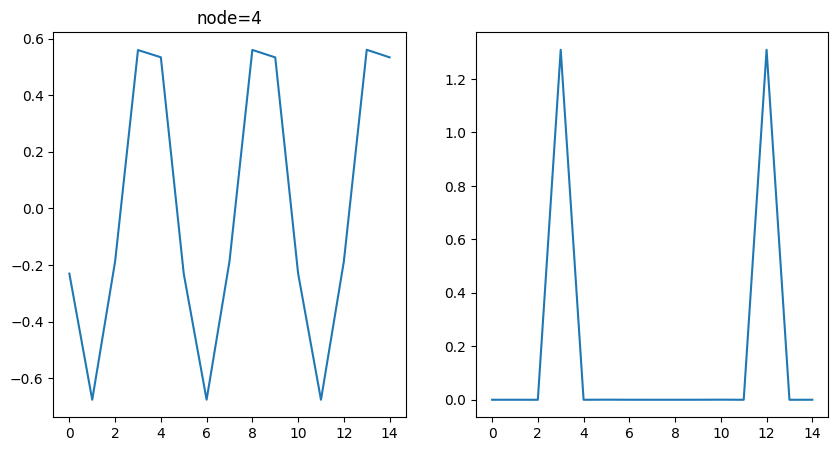

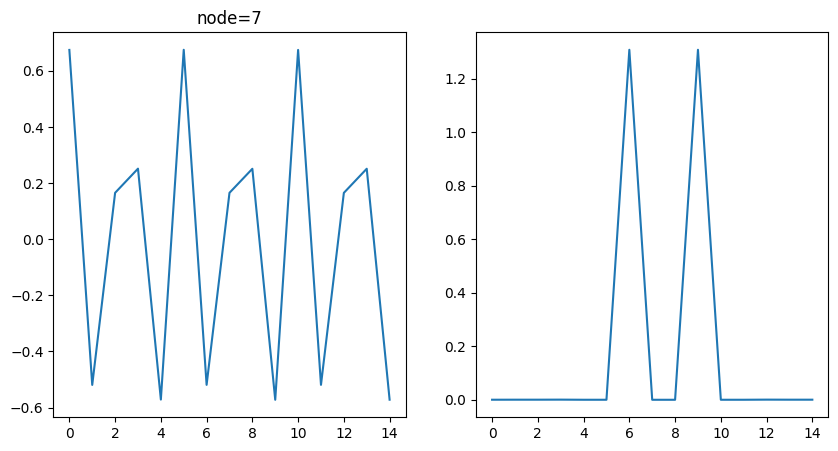

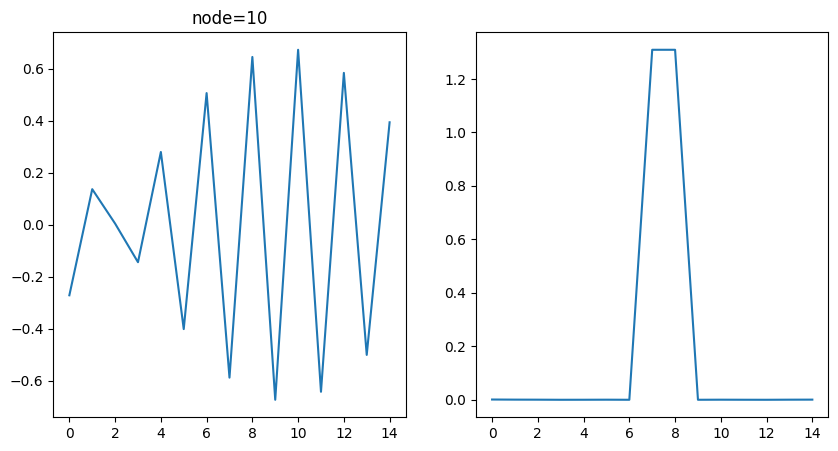

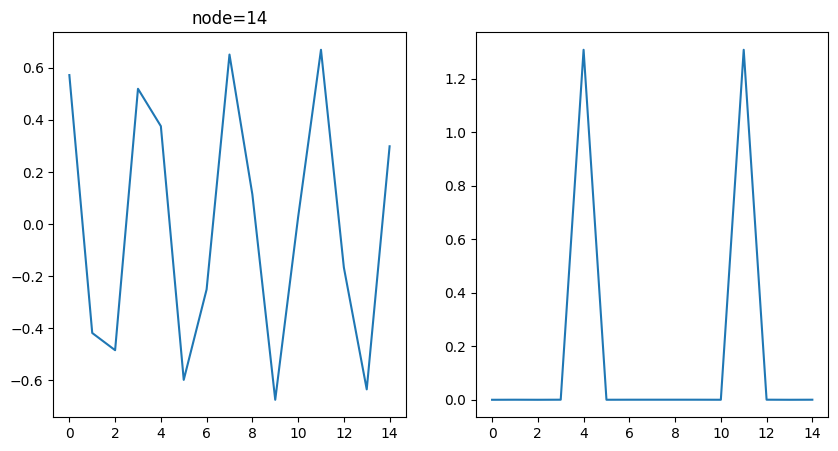

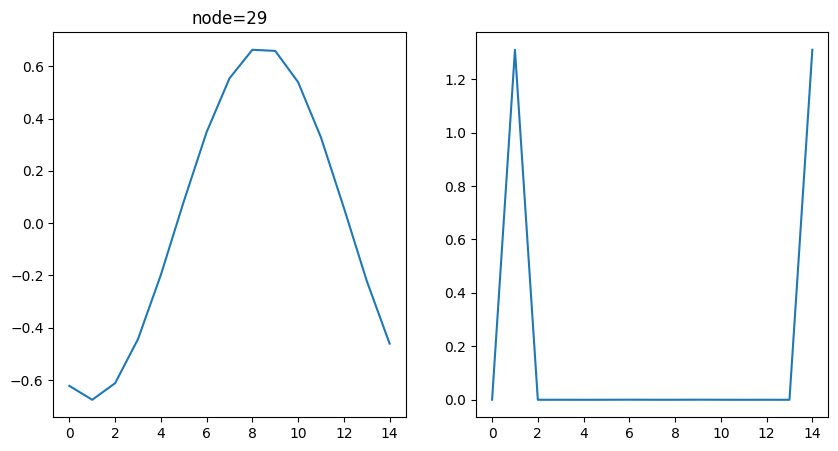

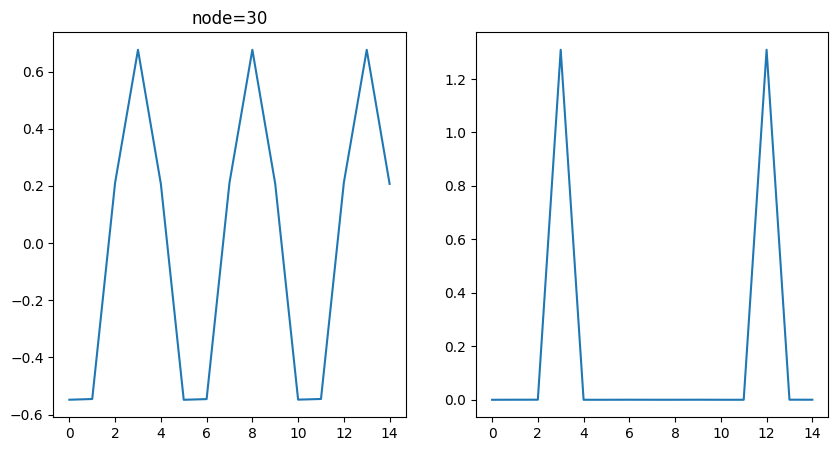

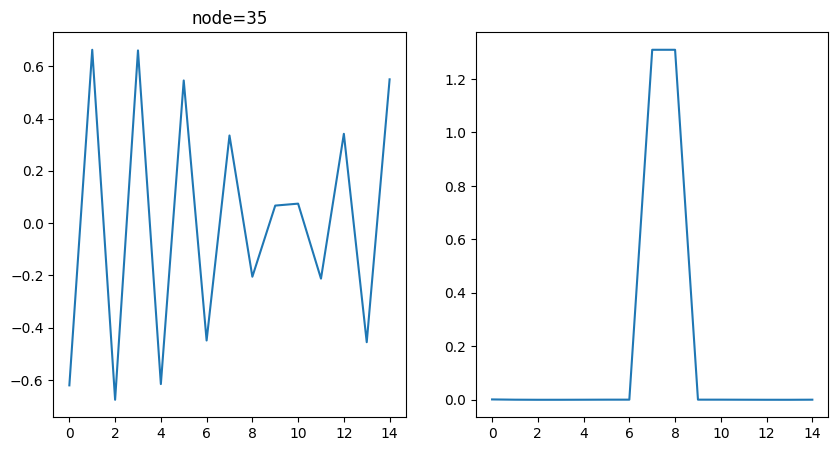

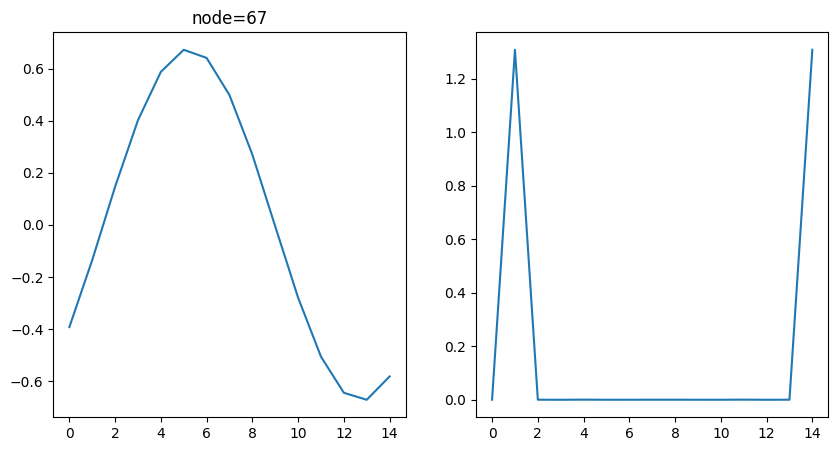

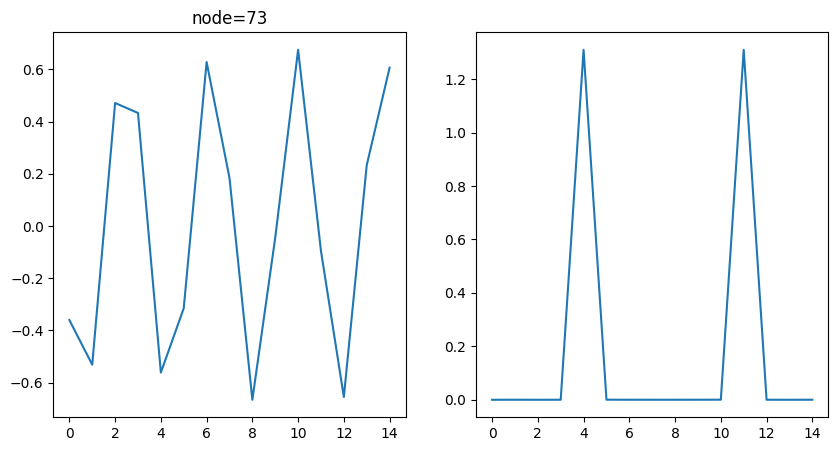

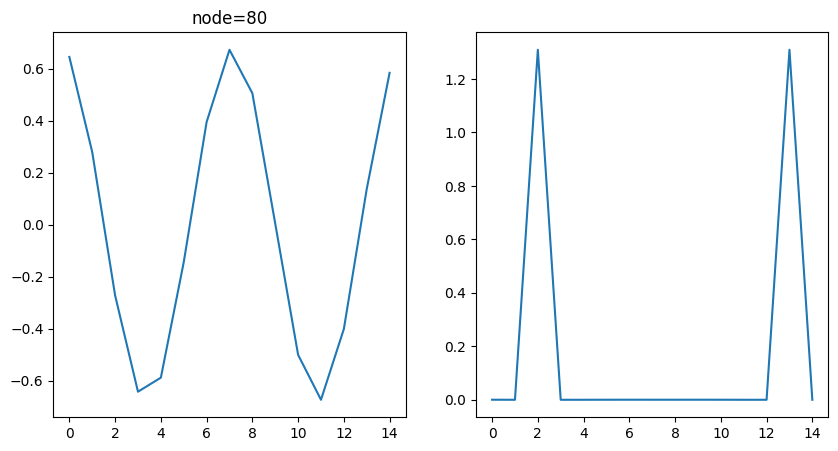

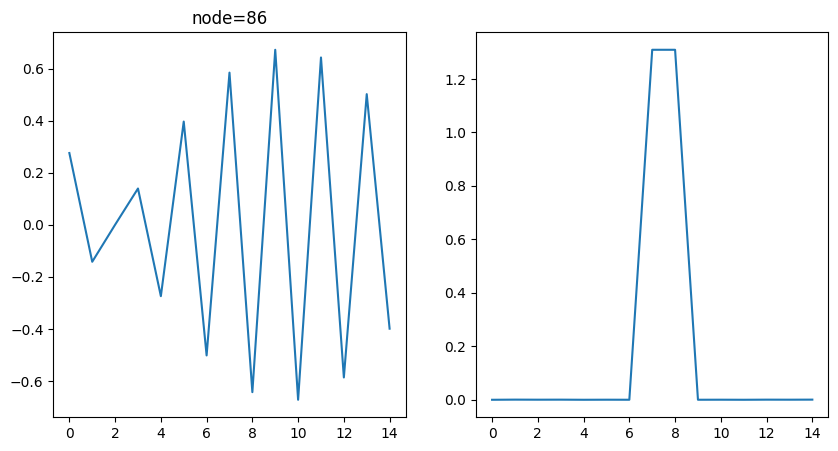

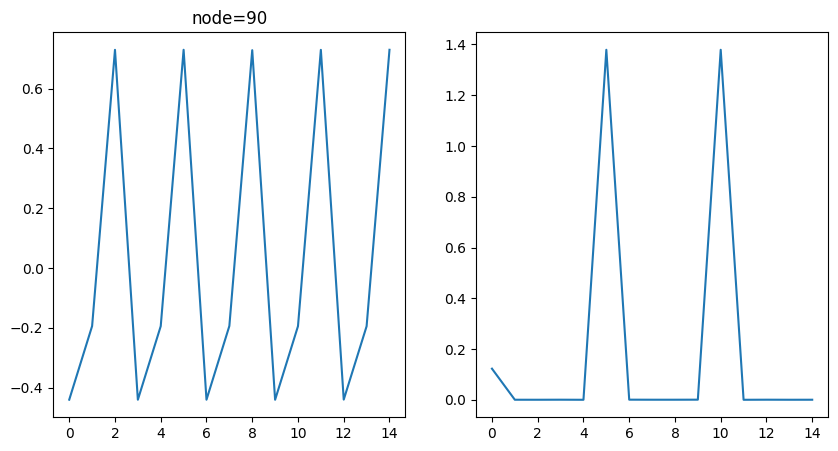

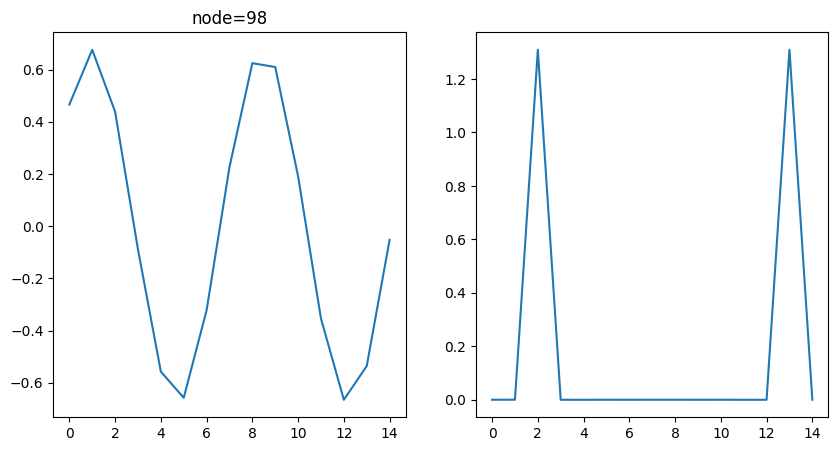

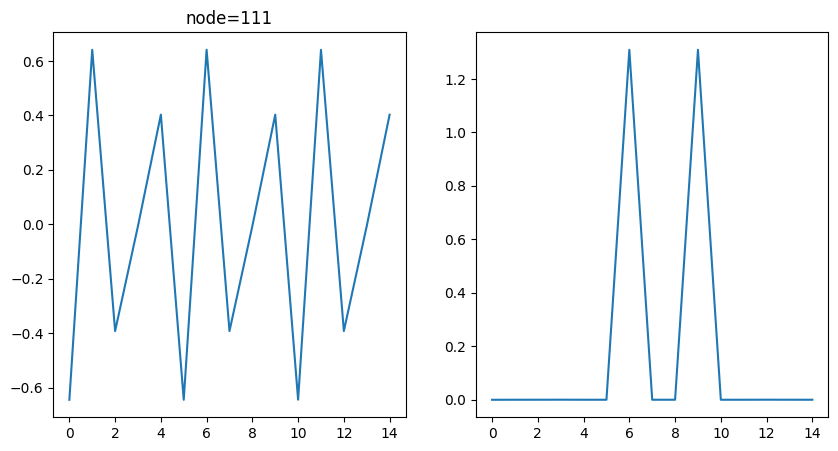

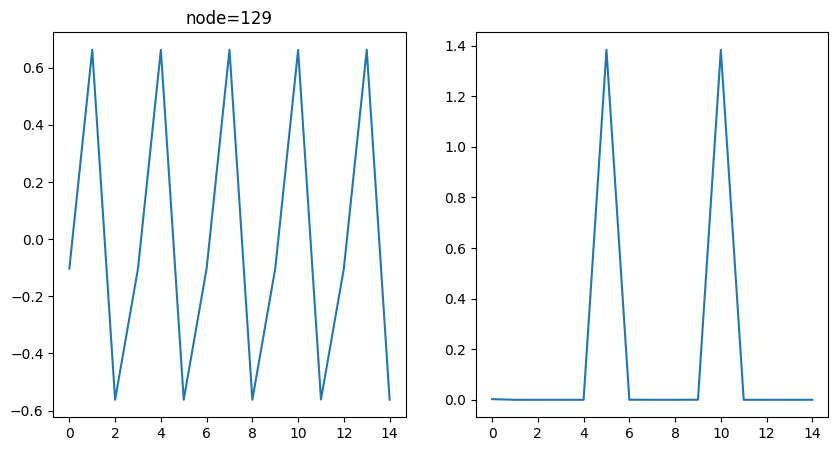

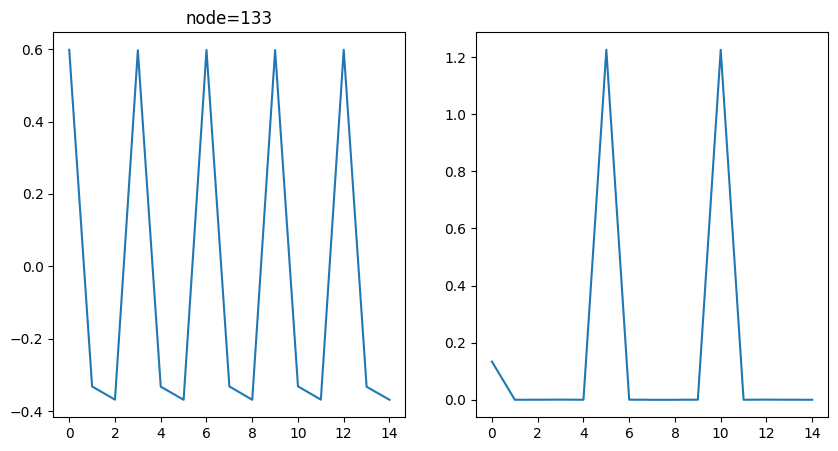

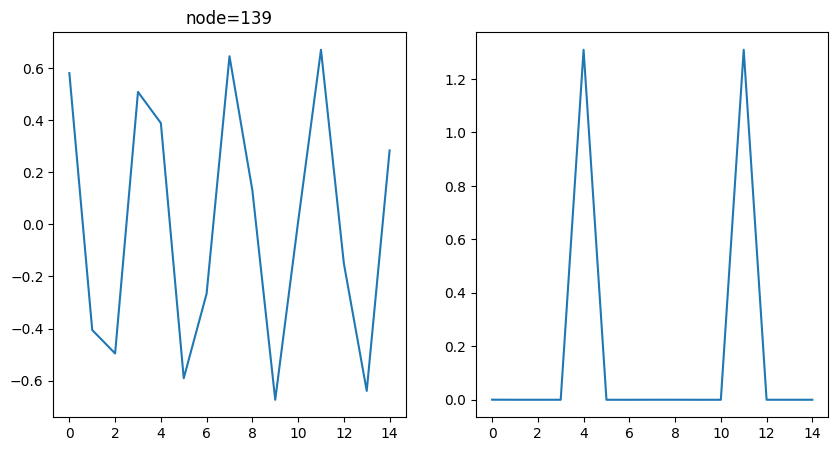

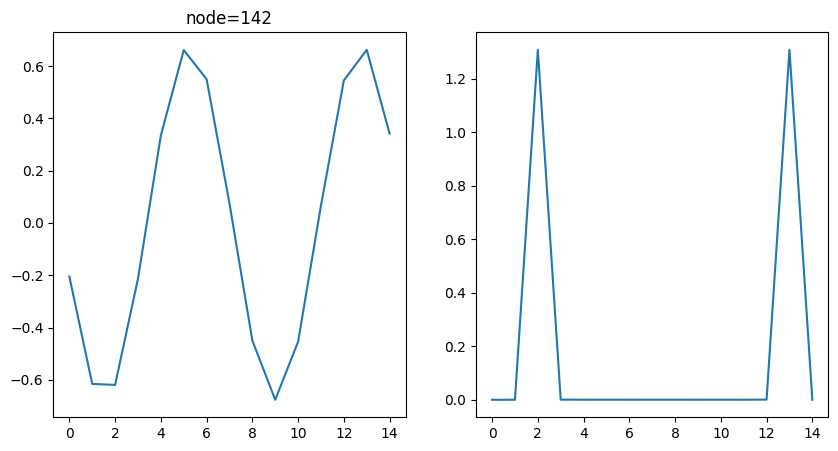

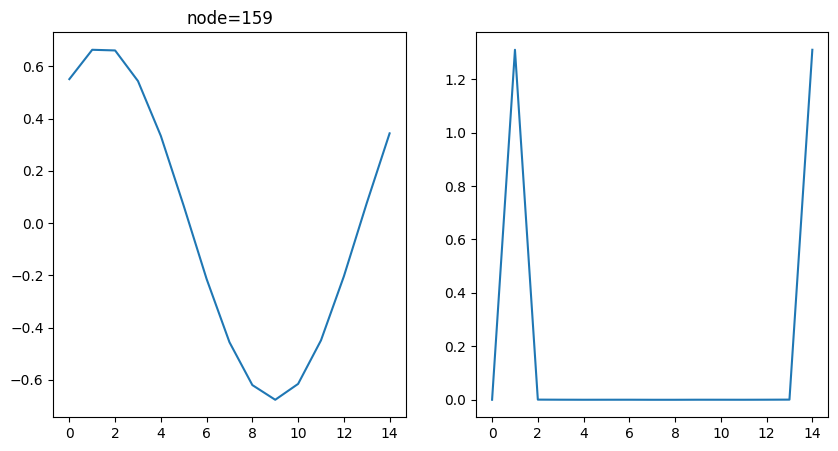

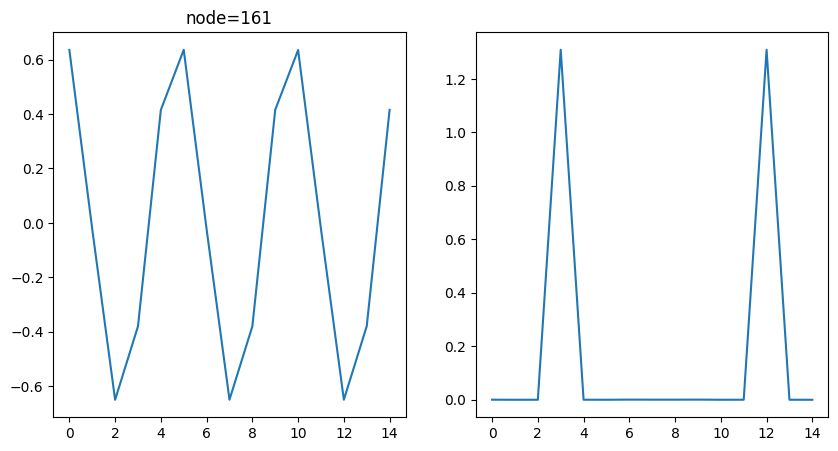

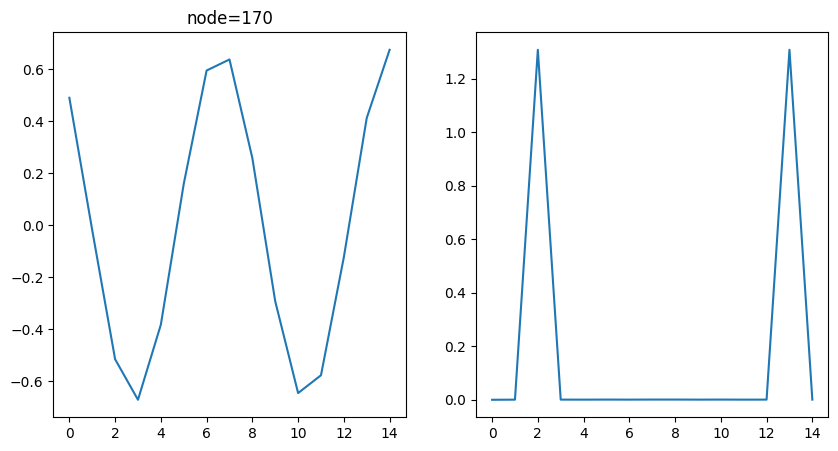

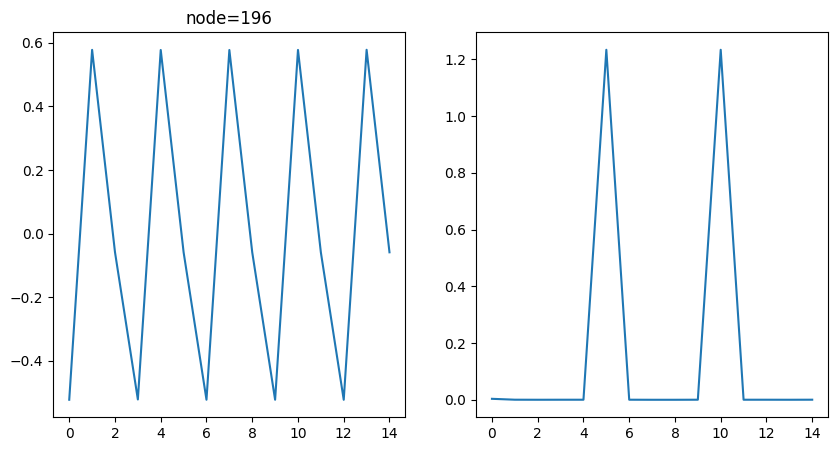

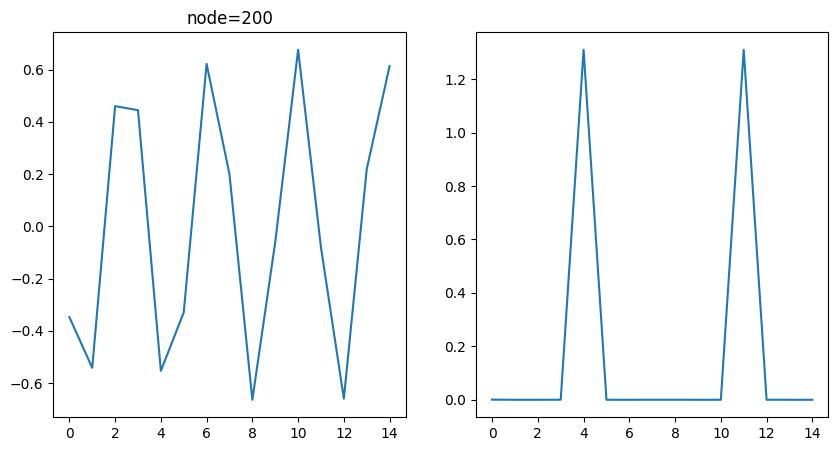

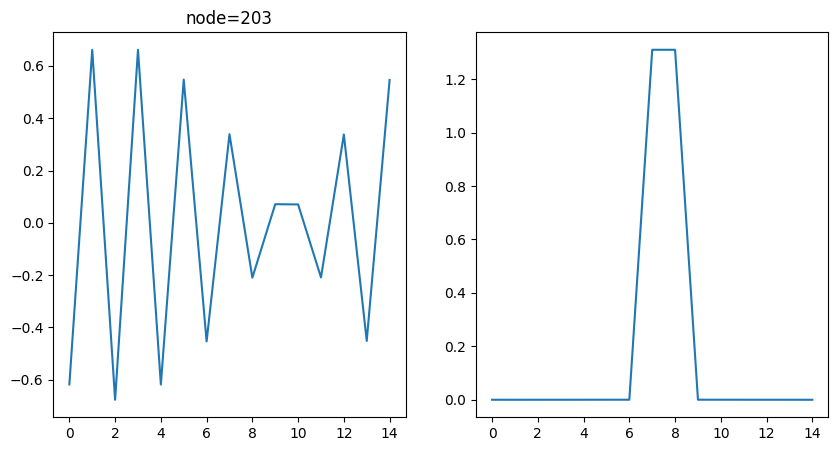

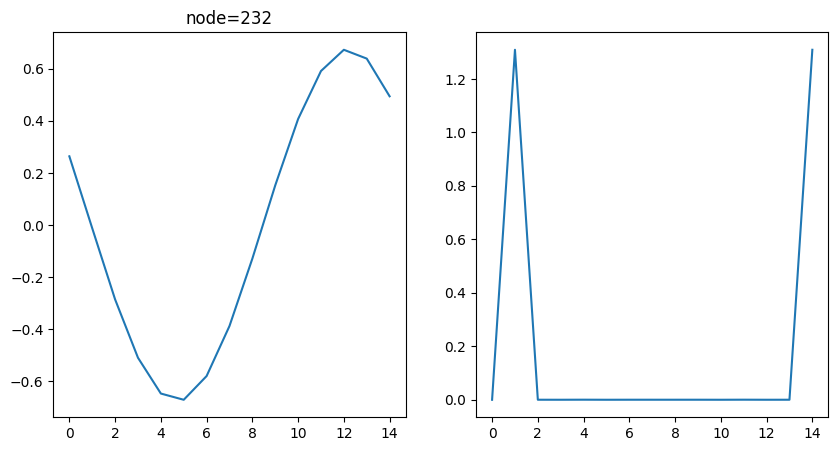

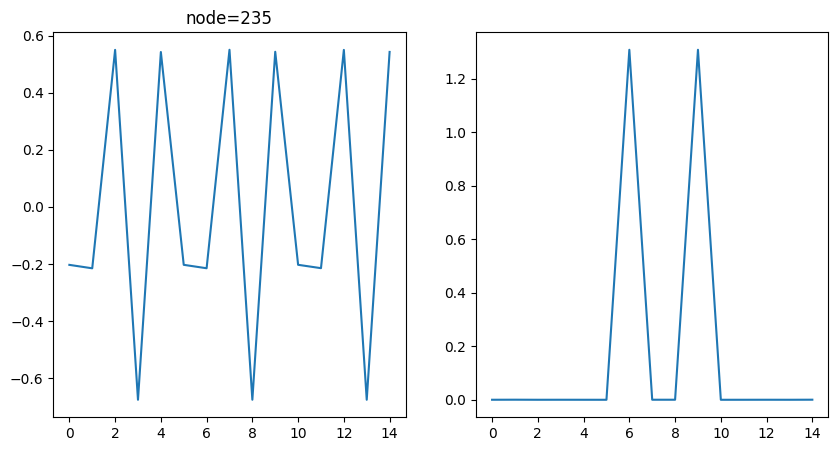

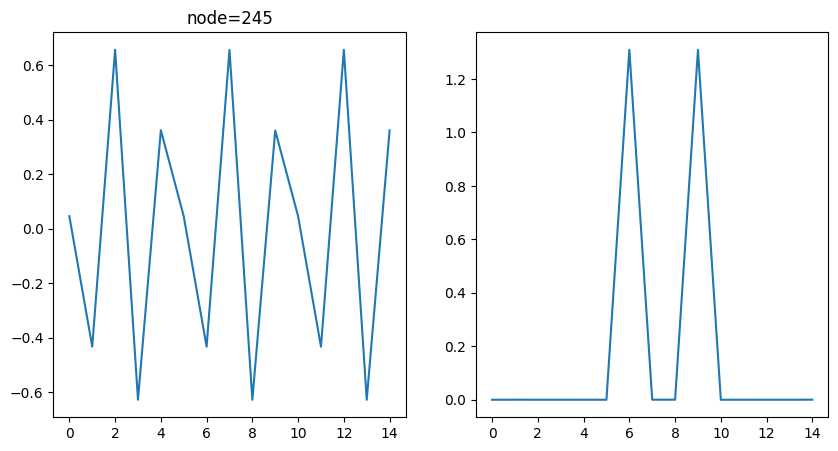

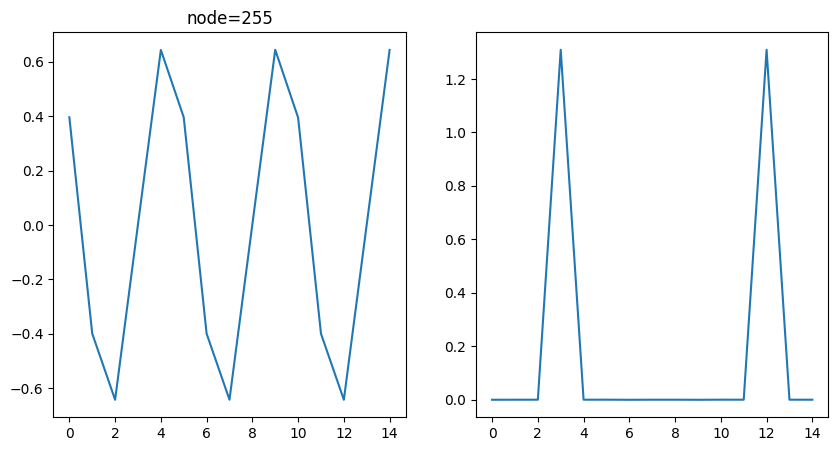

In [569]:
indices = (w.norm(dim=1) > 0.3).nonzero().squeeze()
print(indices.size())

for i in indices:
    v = w[i, :d].cpu()
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(v)
    plt.title(f"node={i}")
    plt.subplot(1, 2, 2)
    # Fourier bases
    plt.plot((U.t() @ v.to(complex_type)).abs())
    # plt.axis([0, d, 0, 1.5])

    plt.show()

In [118]:
w

tensor([[ 0.0507,  0.0390,  0.0651,  ...,  0.0696,  0.0071,  0.0766],
        [ 0.0078,  0.0128, -0.0331,  ...,  0.1107, -0.1021,  0.0904],
        [ 0.0841, -0.0839, -0.0190,  ..., -0.0565,  0.1041,  0.0133],
        ...,
        [-0.0717,  0.0275, -0.0049,  ...,  0.0722, -0.0691,  0.0744],
        [ 0.0188,  0.0072,  0.0112,  ...,  0.0076,  0.0067,  0.0356],
        [ 0.0955,  0.0208, -0.1159,  ...,  0.0743,  0.0679, -0.1111]],
       device='cuda:0')

In [78]:
F.device

device(type='cuda', index=0)

In [28]:
Vh.size()

torch.Size([1024, 1024])

In [31]:
(F@W).size()

torch.Size([529, 1024])

In [57]:
(torch.rand(d, d) > 0.4).nonzero()

tensor([[0, 0],
        [0, 2],
        [1, 0],
        [1, 1],
        [1, 2],
        [1, 3],
        [1, 6],
        [2, 1],
        [2, 2],
        [2, 6],
        [3, 0],
        [3, 2],
        [3, 3],
        [3, 4],
        [3, 5],
        [4, 1],
        [4, 2],
        [4, 3],
        [4, 4],
        [5, 3],
        [5, 4],
        [5, 5],
        [6, 2],
        [6, 6]])

In [397]:
n = 7

S = torch.rand(n).diag()
B = torch.randn(n, n)
B = B + B.t()

sigmas = torch.rand(n)
C = sigmas[:,None] - sigmas[None,:]
C = 1 / C
for i in range(n):
    C[i,i] = 0

alpha = 0.01
Bs = []

# Run the dynamics
for t in range(1000):
    dB = B @ (B * C) @ S - S @ (B * C) @ B
    B = B + alpha * dB
    Bs.append(B)
    
    

In [388]:
Bnorm = [B.norm() for B in Bs]

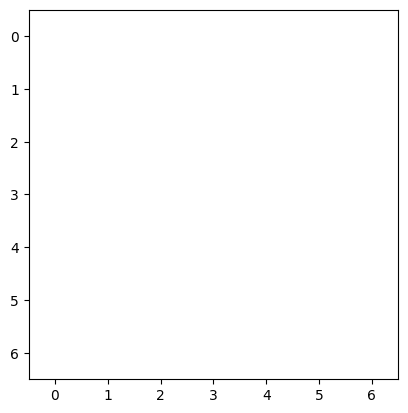

In [398]:
plt.imshow(Bs[600])

In [395]:
Bs[400]

tensor([[ 5.2279,  2.3694, -0.9511,  0.4117, -1.9416,  1.5348,  5.2692],
        [ 2.3694,  0.1375, -5.4441, -0.1462,  4.2208, -0.3212, -1.4143],
        [-0.9511, -5.4438, -8.2060, -0.4916,  3.9089, -2.1406, -2.1272],
        [ 0.4117, -0.1461, -0.4916,  0.5501, -4.8188,  1.0876,  4.0954],
        [-1.9415,  4.2207,  3.9089, -4.8188, -1.6433,  0.6979, -1.3472],
        [ 1.5348, -0.3212, -2.1406,  1.0876,  0.6979, -0.8920,  0.6845],
        [ 5.2692, -1.4143, -2.1271,  4.0954, -1.3472,  0.6845,  0.6267]])

In [399]:
C

tensor([[  0.0000,   6.0254,   4.1059,  -5.5097,   6.6118, -48.4076,   2.7480],
        [ -6.0254,   0.0000,  12.8888,  -2.8780, -67.9286,  -5.3584,   5.0523],
        [ -4.1059, -12.8888,   0.0000,  -2.3527, -10.8333,  -3.7849,   8.3095],
        [  5.5097,   2.8780,   2.3527,   0.0000,   3.0053,   6.2173,   1.8335],
        [ -6.6118,  67.9286,  10.8333,  -3.0053,   0.0000,  -5.8173,   4.7025],
        [ 48.4076,   5.3584,   3.7849,  -6.2173,   5.8173,   0.0000,   2.6004],
        [ -2.7480,  -5.0523,  -8.3095,  -1.8335,  -4.7025,  -2.6004,   0.0000]])

In [415]:
S = torch.rand(n).diag()
C = torch.randn(n, n)
C = C - C.t()

R = torch.randn(n, n)
R = R + R.t()

_, U = torch.linalg.eigh(R)

A = torch.randn(n, n)

U_gt, _, _ = torch.linalg.svd(A)

alpha = 0.01

for i in range(10000):
    inner_prod = U.t() @ U_gt
    inner_prod = inner_prod.pow(2)
    if i % 100 == 0:
        print(inner_prod.diag().sum() / inner_prod.sum())
    
    dU = U @ ((S @ U.t() @ A @ A.t() @ U @ S) * C)
    U = U + alpha * dU
    
    # Make sure U is stable
    # U, _, _ = torch.linalg.svd(U)
    U = U / U.norm(dim=0,keepdim=True)

tensor(0.2346)
tensor(0.2107)
tensor(0.1543)
tensor(0.1926)
tensor(0.1812)
tensor(0.1468)
tensor(0.1308)
tensor(0.1895)
tensor(0.2071)
tensor(0.1400)
tensor(0.2291)
tensor(0.1775)
tensor(0.2722)
tensor(0.2189)
tensor(0.3371)
tensor(0.2641)
tensor(0.2290)
tensor(0.3419)
tensor(0.3007)
tensor(0.2469)
tensor(0.2930)
tensor(0.2523)
tensor(0.3065)
tensor(0.2773)
tensor(0.2931)
tensor(0.2190)
tensor(0.3031)
tensor(0.2376)
tensor(0.2441)
tensor(0.2388)
tensor(0.2570)
tensor(0.2243)
tensor(0.3390)
tensor(0.1985)
tensor(0.2848)
tensor(0.1593)
tensor(0.2071)
tensor(0.1543)
tensor(0.1401)
tensor(0.2233)
tensor(0.1638)
tensor(0.1957)
tensor(0.1741)
tensor(0.2500)
tensor(0.1467)
tensor(0.2065)
tensor(0.2066)
tensor(0.1993)
tensor(0.1742)
tensor(0.2211)
tensor(0.1919)
tensor(0.2251)
tensor(0.1938)
tensor(0.2722)
tensor(0.2309)
tensor(0.2782)
tensor(0.2163)
tensor(0.2476)
tensor(0.2592)
tensor(0.2054)
tensor(0.2754)
tensor(0.2173)
tensor(0.2207)
tensor(0.2438)
tensor(0.2596)
tensor(0.2461)
tensor(0.2

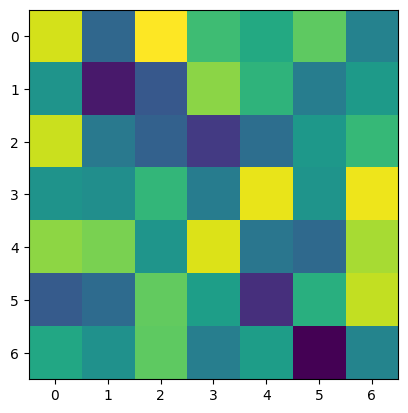

In [416]:
plt.imshow(U)

In [417]:
U.t() @ U

tensor([[ 1.0000,  0.0037,  0.0596,  0.0034, -0.0183, -0.0718, -0.0900],
        [ 0.0037,  1.0000,  0.0268,  0.0233, -0.0041, -0.0131, -0.0111],
        [ 0.0596,  0.0268,  1.0000,  0.0570,  0.0164,  0.0986,  0.0064],
        [ 0.0034,  0.0233,  0.0570,  1.0000, -0.0368, -0.0094,  0.0345],
        [-0.0183, -0.0041,  0.0164, -0.0368,  1.0000, -0.0167, -0.1364],
        [-0.0718, -0.0131,  0.0986, -0.0094, -0.0167,  1.0000, -0.0533],
        [-0.0900, -0.0111,  0.0064,  0.0345, -0.1364, -0.0533,  1.0000]])

In [409]:
C

tensor([[ 0.0000,  0.4951, -0.1192,  2.1297, -1.6246,  1.6562, -0.3304],
        [-0.4951,  0.0000,  0.0700, -3.2754, -0.5382,  1.0054, -0.7879],
        [ 0.1192, -0.0700,  0.0000, -2.6245, -0.1097,  2.0995, -0.9421],
        [-2.1297,  3.2754,  2.6245,  0.0000,  0.2984, -0.3900, -0.7046],
        [ 1.6246,  0.5382,  0.1097, -0.2984,  0.0000,  1.1390, -0.8681],
        [-1.6562, -1.0054, -2.0995,  0.3900, -1.1390,  0.0000,  0.1569],
        [ 0.3304,  0.7879,  0.9421,  0.7046,  0.8681, -0.1569,  0.0000]])

In [557]:
n = 13

B = torch.randn(n, n)
B = B @ B.t()

A = torch.randn(n, n)
A = A @ A.t()

alpha = .0001

for i in range(10000):
    if i % 100 == 0:
        print((A @ B - B @ A).norm() / A.norm() / B.norm())
        
    D, U = torch.linalg.eigh(A)
    invA = U @ (D + 1e-4).pow(-1).diag() @ U.t()
    
    dA = invA @ B + B @ invA
    A = A + alpha * dA

tensor(0.2438)
tensor(0.2415)
tensor(0.2401)
tensor(0.2389)
tensor(0.2380)
tensor(0.2371)
tensor(0.2362)
tensor(0.2355)
tensor(0.2348)
tensor(0.2341)
tensor(0.2334)
tensor(0.2328)
tensor(0.2322)
tensor(0.2316)
tensor(0.2311)
tensor(0.2305)
tensor(0.2300)
tensor(0.2294)
tensor(0.2289)
tensor(0.2284)
tensor(0.2279)
tensor(0.2275)
tensor(0.2270)
tensor(0.2265)
tensor(0.2261)
tensor(0.2256)
tensor(0.2252)
tensor(0.2248)
tensor(0.2243)
tensor(0.2239)
tensor(0.2235)
tensor(0.2231)
tensor(0.2227)
tensor(0.2223)
tensor(0.2219)
tensor(0.2215)
tensor(0.2211)
tensor(0.2207)
tensor(0.2203)
tensor(0.2200)
tensor(0.2196)
tensor(0.2192)
tensor(0.2189)
tensor(0.2185)
tensor(0.2182)
tensor(0.2178)
tensor(0.2175)
tensor(0.2171)
tensor(0.2168)
tensor(0.2164)
tensor(0.2161)
tensor(0.2158)
tensor(0.2154)
tensor(0.2151)
tensor(0.2148)
tensor(0.2144)
tensor(0.2141)
tensor(0.2138)
tensor(0.2135)
tensor(0.2132)
tensor(0.2128)
tensor(0.2125)
tensor(0.2122)
tensor(0.2119)
tensor(0.2116)
tensor(0.2113)
tensor(0.2